In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../../datasets/house_prices_dataset/house_prices_train.csv")
del df['Id']

target = "SalePrice"
num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

In [3]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Dataset preprocessing

In [4]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [5]:
enc = OneHotEncoder(sparse_output=False, drop='first')
encoded_cat_df = enc.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat_df, columns=enc.get_feature_names_out(cat_features)).astype('Int16')
encoded_cat_features = list(encoded_cat_df.columns)
encoded_cat_df.shape

(1460, 224)

In [6]:
encoded_df = pd.concat([df, encoded_cat_df], axis=1)

In [7]:
encoded_df['class'] = encoded_df[target].apply(lambda x: 1 if x >= 250_000 else 0)
clf_target = 'class'
encoded_df['class'].value_counts()

class
0    1235
1     225
Name: count, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_df[num_features+cat_features+encoded_cat_features], 
    encoded_df[[target, clf_target]], 
    test_size=0.33, random_state=2025)

df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [9]:
linear_features = num_features+encoded_cat_features

In [10]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target, clf_target]+ cat_features]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target, clf_target]+ cat_features]], axis=1)

# Simple Linear Regression

In [11]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [12]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [13]:
simple_model = LinearRegression()
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

LinearRegression()

In [14]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [15]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.9342844366357325
MSE = 397886427.41475236
RMSE = 19947.090700519522
MAE = 12432.844048246428
MAPE = 0.07180052924794227


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_18256/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [16]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.7636131923354911
MSE = 1611764410.0001333
RMSE = 40146.78579911639
MAE = 19483.623690172844
MAPE = 0.11750337980686873


In [17]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.934284,3.978864e+08,19947.090701,12432.844048,0.071801
0,simple_regression,test,0.763613,1.611764e+09,40146.785799,19483.623690,0.117503


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [18]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

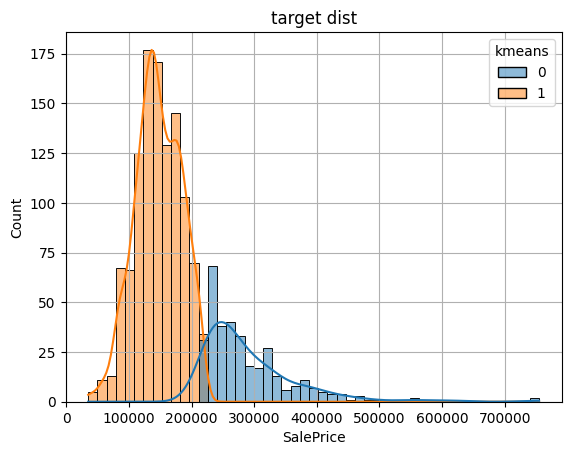

In [19]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [20]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [21]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       234
           1       1.00      1.00      1.00       744

    accuracy                           1.00       978
   macro avg       0.99      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [22]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       110
           1       0.97      0.97      0.97       372

    accuracy                           0.96       482
   macro avg       0.94      0.94      0.94       482
weighted avg       0.96      0.96      0.96       482



### fit regression

In [23]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [24]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (234, 306) (744, 306)
test (109, 307) (373, 307)


In [25]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [26]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.9786156445534678
MSE = 129475338.19384952
RMSE = 11378.723047594116
MAE = 7933.004708253685
MAPE = 0.04922101912852102
segm_kmeans2_regression, -- Type Dataset - test
R2 = -0.18701140974826247
MSE = 8093441268.565257
RMSE = 89963.55522413093
MAE = 31624.31954051486
MAPE = 0.16013594827858232


## fit k-means 3  clusters on target

### clustering

In [27]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

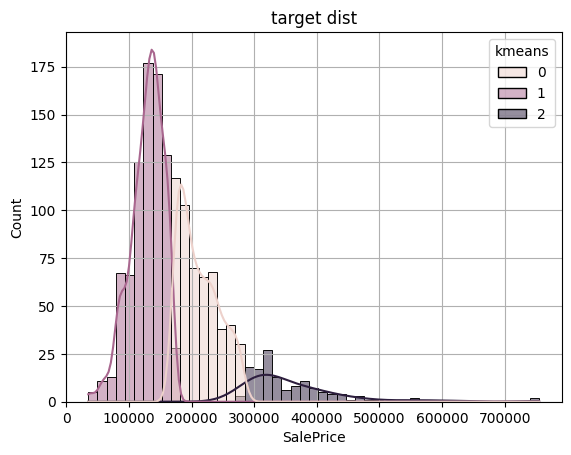

In [28]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [29]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [30]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       353
           1       0.99      0.98      0.99       529
           2       0.96      0.98      0.97        96

    accuracy                           0.98       978
   macro avg       0.97      0.98      0.98       978
weighted avg       0.98      0.98      0.98       978



In [31]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       178
           1       0.95      0.92      0.93       263
           2       0.81      0.73      0.77        41

    accuracy                           0.89       482
   macro avg       0.87      0.85      0.86       482
weighted avg       0.90      0.89      0.89       482



### fit regression

In [32]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [33]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (353, 306) (529, 306) (96, 306)
test (188, 307) (257, 307) (37, 307)


In [34]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [35]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9882945567395156
MSE = 70872663.36596134
RMSE = 8418.590343160864
MAE = 5650.373919201057
MAPE = 0.03891827949408407
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.08366325088517035
MSE = 6247890795.558334
RMSE = 79043.60059839339
MAE = 27132.398580505214
MAPE = 0.14797421650507572


## fit 2 clusters on features

### clustering

In [36]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

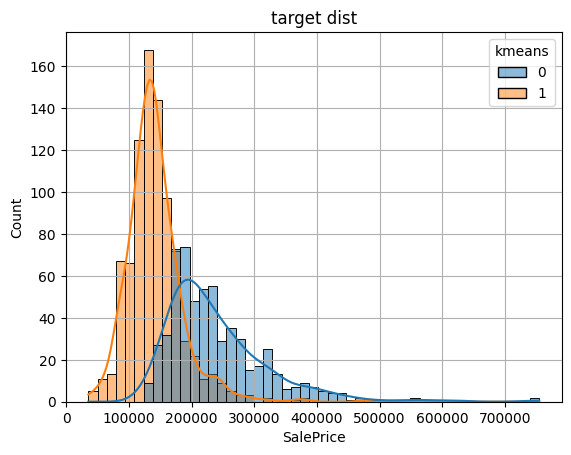

In [37]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [38]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [39]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       573

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [40]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       186
           1       0.98      0.98      0.98       296

    accuracy                           0.98       482
   macro avg       0.97      0.97      0.97       482
weighted avg       0.98      0.98      0.98       482



### fit regression

In [41]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [42]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (405, 306) (573, 306)
test (186, 307) (296, 307)


In [43]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [44]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.9655360808489799
MSE = 208667855.27956793
RMSE = 14445.340261813424
MAE = 9554.335720901561
MAPE = 0.05633651355504194
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.6248617506403875
MSE = 2557818201.1142673
RMSE = 50574.8771734966
MAE = 22861.41735881895
MAPE = 0.13798211984938602


## fit 3 clusters on features

### clustering

In [45]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

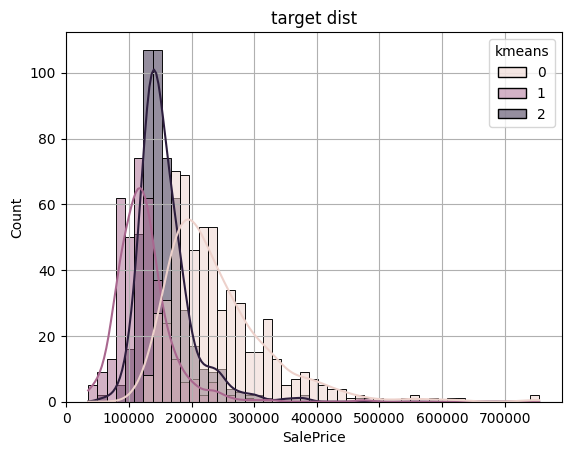

In [46]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [47]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [48]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       391
           1       1.00      0.99      1.00       241
           2       0.99      1.00      1.00       346

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



In [49]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       180
           1       0.95      0.90      0.92       134
           2       0.93      0.95      0.94       168

    accuracy                           0.95       482
   macro avg       0.95      0.95      0.95       482
weighted avg       0.95      0.95      0.95       482



### fit regression

In [50]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [51]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (391, 306) (241, 306) (346, 306)
test (182, 307) (128, 307) (172, 307)


In [52]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [53]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.97162745257806
MSE = 171786574.63217717
RMSE = 13106.737757053705
MAE = 8019.019145406313
MAPE = 0.04436813812435566
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.6385079249326119
MSE = 2464774015.297936
RMSE = 49646.49046305223
MAE = 25150.366187210504
MAPE = 0.1550000322973212


# Catboost

In [54]:
catboost_features = num_features+cat_features

In [55]:
cat_model = cat.CatBoostRegressor(random_seed = 2025, cat_features=cat_features, verbose=False)
cat_model.fit(df_train[catboost_features], df_train[target])

In [56]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [57]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9826189666310685
MSE = 105236521.12067415
RMSE = 10258.485322925317
MAE = 7074.099107043198
MAPE = 0.04287479062542724


In [58]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.8925282018563128
MSE = 732778707.230372
RMSE = 27069.88561539136
MAE = 15651.013002386228
MAPE = 0.09401566317537778


In [59]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.934284,3.978864e+08,19947.090701,12432.844048,0.071801
0,segm_kmeans2_regression,train,0.978616,1.294753e+08,11378.723048,7933.004708,0.049221
0,segm_kmeans3_regression,train,0.988295,7.087266e+07,8418.590343,5650.373919,0.038918
0,segm_kmeans2onFeatures_regression,train,0.965536,2.086679e+08,14445.340262,9554.335721,0.056337
0,segm_kmeans3onFeatures_regression,train,0.971627,1.717866e+08,13106.737757,8019.019145,0.044368
0,catboost_regression,train,0.982619,1.052365e+08,10258.485323,7074.099107,0.042875


In [60]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.763613,1.611764e+09,40146.785799,19483.623690,0.117503
0,segm_kmeans2_regression,test,-0.187011,8.093441e+09,89963.555224,31624.319541,0.160136
0,segm_kmeans3_regression,test,0.083663,6.247891e+09,79043.600598,27132.398581,0.147974
0,segm_kmeans2onFeatures_regression,test,0.624862,2.557818e+09,50574.877173,22861.417359,0.137982
0,segm_kmeans3onFeatures_regression,test,0.638508,2.464774e+09,49646.490463,25150.366187,0.155000
0,catboost_regression,test,0.892528,7.327787e+08,27069.885615,15651.013002,0.094016
